In [1]:
import os
import shutil
from utilities import *
from PIL import Image
import tensorflow as tf
from keras.applications.efficientnet import EfficientNetB0
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import pprint
import re
import tqdm


<h3> Data Pre Processing </h3>

Dataset hierarchy should be "Vendor/Template_Type/File"


In [2]:
path_to_initial_dataset='Dataset_EDA'
for main_folder in os.listdir(path_to_initial_dataset):
    if 'T' in main_folder.split('_')[-1] and main_folder[-1].isdigit():
        pass
    else: 
        to_make_folders=list(set([(i.split('.')[0]).split('_')[-1] for i in os.listdir(path_to_initial_dataset+'/'+main_folder)]))
        [os.mkdir(path_to_initial_dataset+'/'+main_folder+'_'+i) for i in to_make_folders]    
        for files in tqdm.tqdm(os.listdir(path_to_initial_dataset+'/'+main_folder)):
            to_move=str(main_folder)+'_'+(files.split('.')[0]).split('_')[-1]   
            try:
                shutil.move(path_to_initial_dataset+'/'+main_folder+'/'+files,path_to_initial_dataset+'/'+to_move+'/'+files)
            except:
                
                pass

[shutil.rmtree(path_to_initial_dataset+'/'+i) for i in os.listdir(path_to_initial_dataset) if '_T' not in i]


[]

In [3]:
X,Y,map=prepare_all_dataset('Dataset_EDA')#path_of_dataset)
n_class=len(map)
X=get_images_array(X)
Y=np.asarray(Y)

dump_load_map(map,0)
#print(Y)

Y=tf.keras.utils.to_categorical(
    Y, num_classes=n_class, dtype='float32')


class_weights=get_class_weights(Y)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.33)

Here are vendors: ['Dataset_EDA/DHL_T1', 'Dataset_EDA/DHL_T2', 'Dataset_EDA/DHL_T3', 'Dataset_EDA/DHL_T5', 'Dataset_EDA/DHL_T6', 'Dataset_EDA/Slack_T1', 'Dataset_EDA/Slack_T2', 'Dataset_EDA/Slack_T3', 'Dataset_EDA/Slack_T4', 'Dataset_EDA/Slack_T5', 'Dataset_EDA/Slack_T6', 'Dataset_EDA/Slack_T7', 'Dataset_EDA/ULINE_T1', 'Dataset_EDA/ULINE_T2', 'Dataset_EDA/ULINE_T3']

DHL_T1 vendor Processing 


dirs: 100%|██████████| 215/215 [00:07<00:00, 28.36it/s]



DHL_T2 vendor Processing 


dirs: 100%|██████████| 2/2 [00:00<00:00, 14.48it/s]



DHL_T3 vendor Processing 


dirs: 100%|██████████| 32/32 [00:00<00:00, 33.24it/s]



DHL_T5 vendor Processing 


dirs: 100%|██████████| 35/35 [00:01<00:00, 22.59it/s]



DHL_T6 vendor Processing 


dirs: 100%|██████████| 6/6 [00:00<00:00, 31.41it/s]



Slack_T1 vendor Processing 


dirs: 100%|██████████| 16/16 [00:00<00:00, 19.61it/s]



Slack_T2 vendor Processing 


dirs: 100%|██████████| 110/110 [00:04<00:00, 25.61it/s]



Slack_T3 vendor Processing 


dirs: 100%|██████████| 94/94 [00:04<00:00, 20.73it/s]



Slack_T4 vendor Processing 


dirs: 100%|██████████| 101/101 [00:04<00:00, 24.37it/s]



Slack_T5 vendor Processing 


dirs: 100%|██████████| 5/5 [00:00<00:00, 28.20it/s]



Slack_T6 vendor Processing 


dirs: 100%|██████████| 16/16 [00:00<00:00, 26.61it/s]



Slack_T7 vendor Processing 


dirs: 100%|██████████| 3/3 [00:00<00:00, 23.90it/s]



ULINE_T1 vendor Processing 


dirs: 100%|██████████| 6/6 [00:00<00:00, 20.28it/s]



ULINE_T2 vendor Processing 


dirs: 100%|██████████| 173/173 [00:09<00:00, 18.68it/s]



ULINE_T3 vendor Processing 


dirs: 100%|██████████| 195/195 [00:11<00:00, 17.21it/s]


In [4]:
pprint.pprint(class_weights)

{0: 0.31286821705426354,
 1: 33.63333333333333,
 2: 2.1020833333333333,
 3: 1.921904761904762,
 4: 11.21111111111111,
 5: 4.204166666666667,
 6: 0.6115151515151516,
 7: 0.7156028368794326,
 8: 0.666006600660066,
 9: 13.453333333333333,
 10: 4.204166666666667,
 11: 22.42222222222222,
 12: 11.21111111111111,
 13: 0.38882466281310213,
 14: 0.344957264957265}


In [5]:
def Custom_Efficient_Net(image_shape=X[0].shape,output_shape=n_class):
    if 'Efficient_net_custom_doc_type.h5' in os.listdir(os.getcwd()):
        print('Loaded Previous Model ')
        model=tf.keras.models.load_model('Efficient_net_custom_doc_type.h5')
    else:
        print('Initialized New Model') 
        input_val=tf.keras.layers.Input(shape=image_shape)
        model=EfficientNetB0(include_top=False,input_tensor=input_val,weights='imagenet')

        for i in range(int(len(model.layers) * 0.45)):
            model.layers[i].trainable = False

        #model.trainable = False


        x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
        x = tf.keras.layers.BatchNormalization()(x)

        top_dropout_rate = 0.45
        x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
        #x=tf.keras.layers.Flatten()
        output = tf.keras.layers.Dense(output_shape, activation="softmax", name="pred")(x)

        model=tf.keras.Model(inputs=input_val,outputs=output)
    
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

custom_model=Custom_Efficient_Net()

Loaded Previous Model 


In [6]:
callback = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss',mode='auto',restore_best_weights=True )
hist=custom_model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=25,callbacks=[callback],batch_size=64,class_weight=class_weights)

Epoch 1/25
11/11 [==============================] - 41s 3s/step - loss: 1.5189 - accuracy: 0.7914 - val_loss: 1.3360 - val_accuracy: 0.7237
Epoch 2/25
11/11 [==============================] - 23s 2s/step - loss: 0.4906 - accuracy: 0.8698 - val_loss: 0.6608 - val_accuracy: 0.8258
Epoch 3/25
11/11 [==============================] - 21s 2s/step - loss: 0.2052 - accuracy: 0.8846 - val_loss: 0.3490 - val_accuracy: 0.8679
Epoch 4/25
11/11 [==============================] - 21s 2s/step - loss: 0.2740 - accuracy: 0.9453 - val_loss: 0.1860 - val_accuracy: 0.9640
Epoch 5/25
11/11 [==============================] - 22s 2s/step - loss: 0.0949 - accuracy: 0.9453 - val_loss: 0.0794 - val_accuracy: 0.9940
Epoch 6/25
11/11 [==============================] - 22s 2s/step - loss: 0.0544 - accuracy: 0.9793 - val_loss: 0.0468 - val_accuracy: 0.9940
Epoch 7/25
11/11 [==============================] - 22s 2s/step - loss: 0.4521 - accuracy: 0.9749 - val_loss: 0.0466 - val_accuracy: 0.9850
Epoch 8/25
11/11 [==

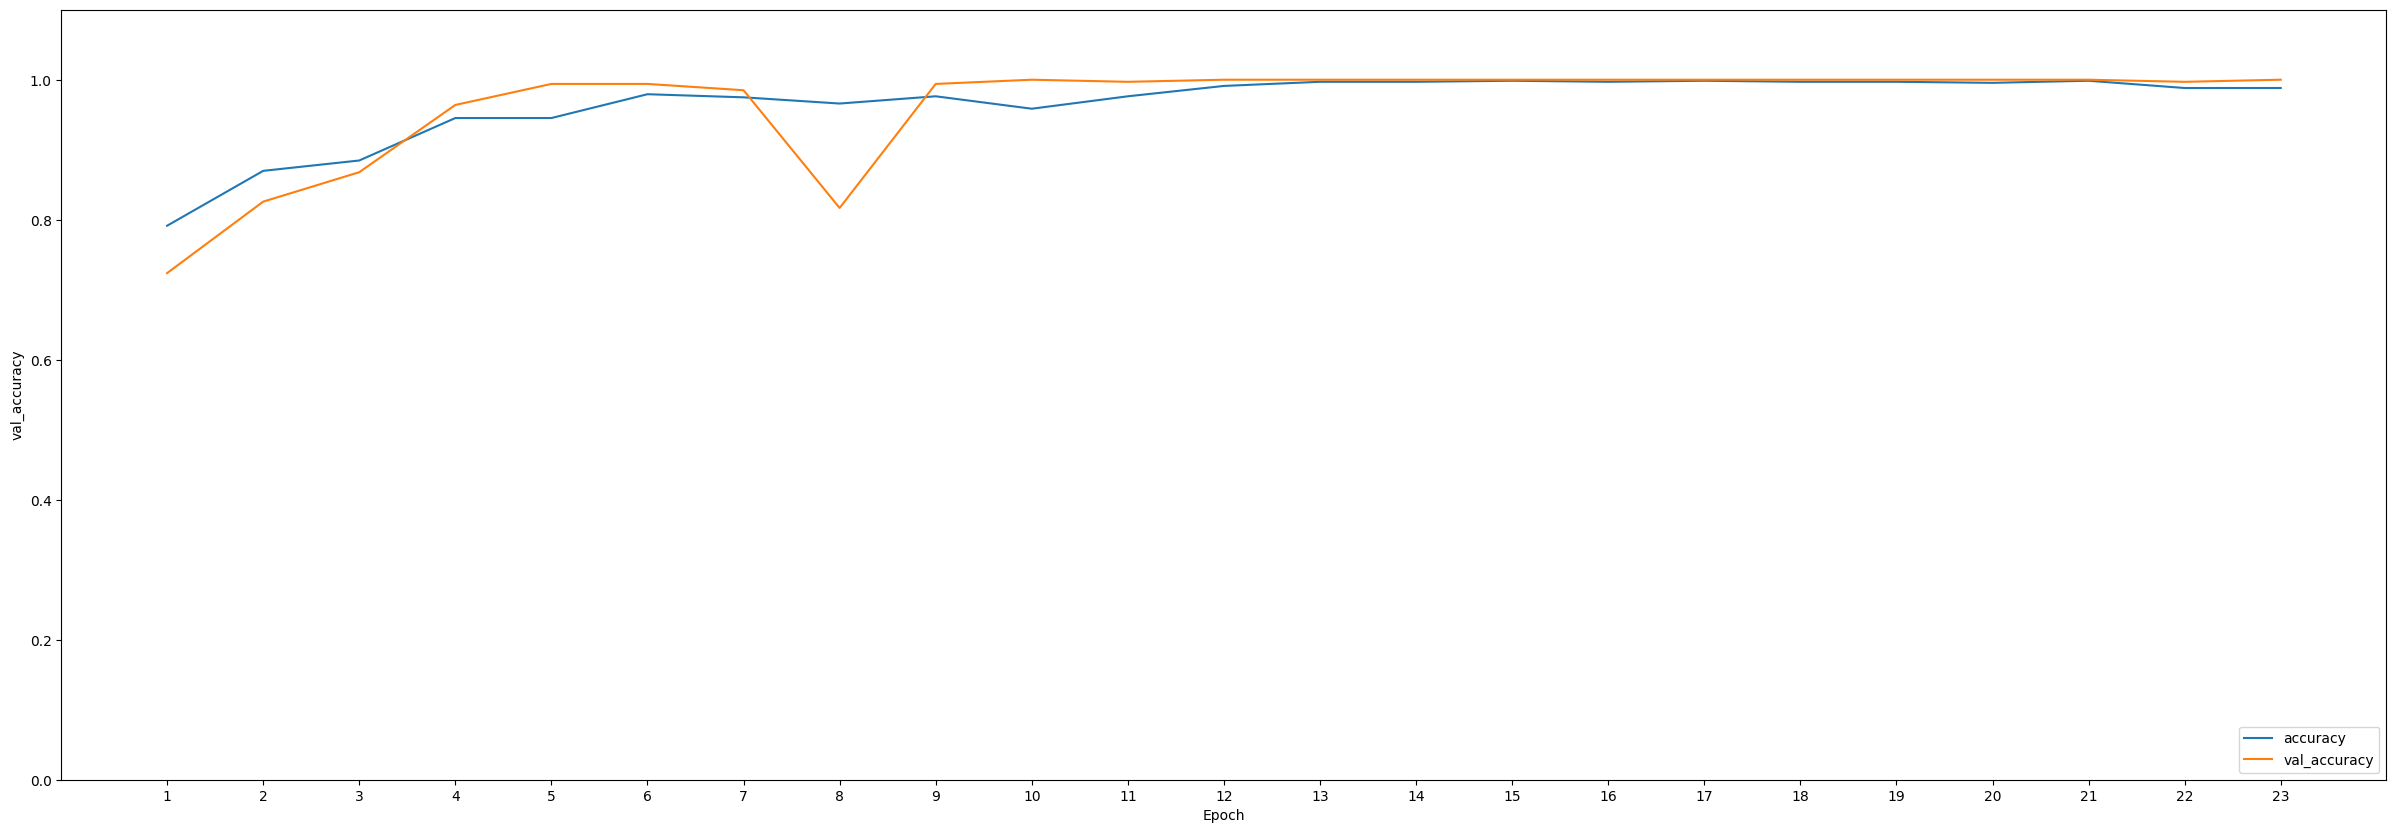

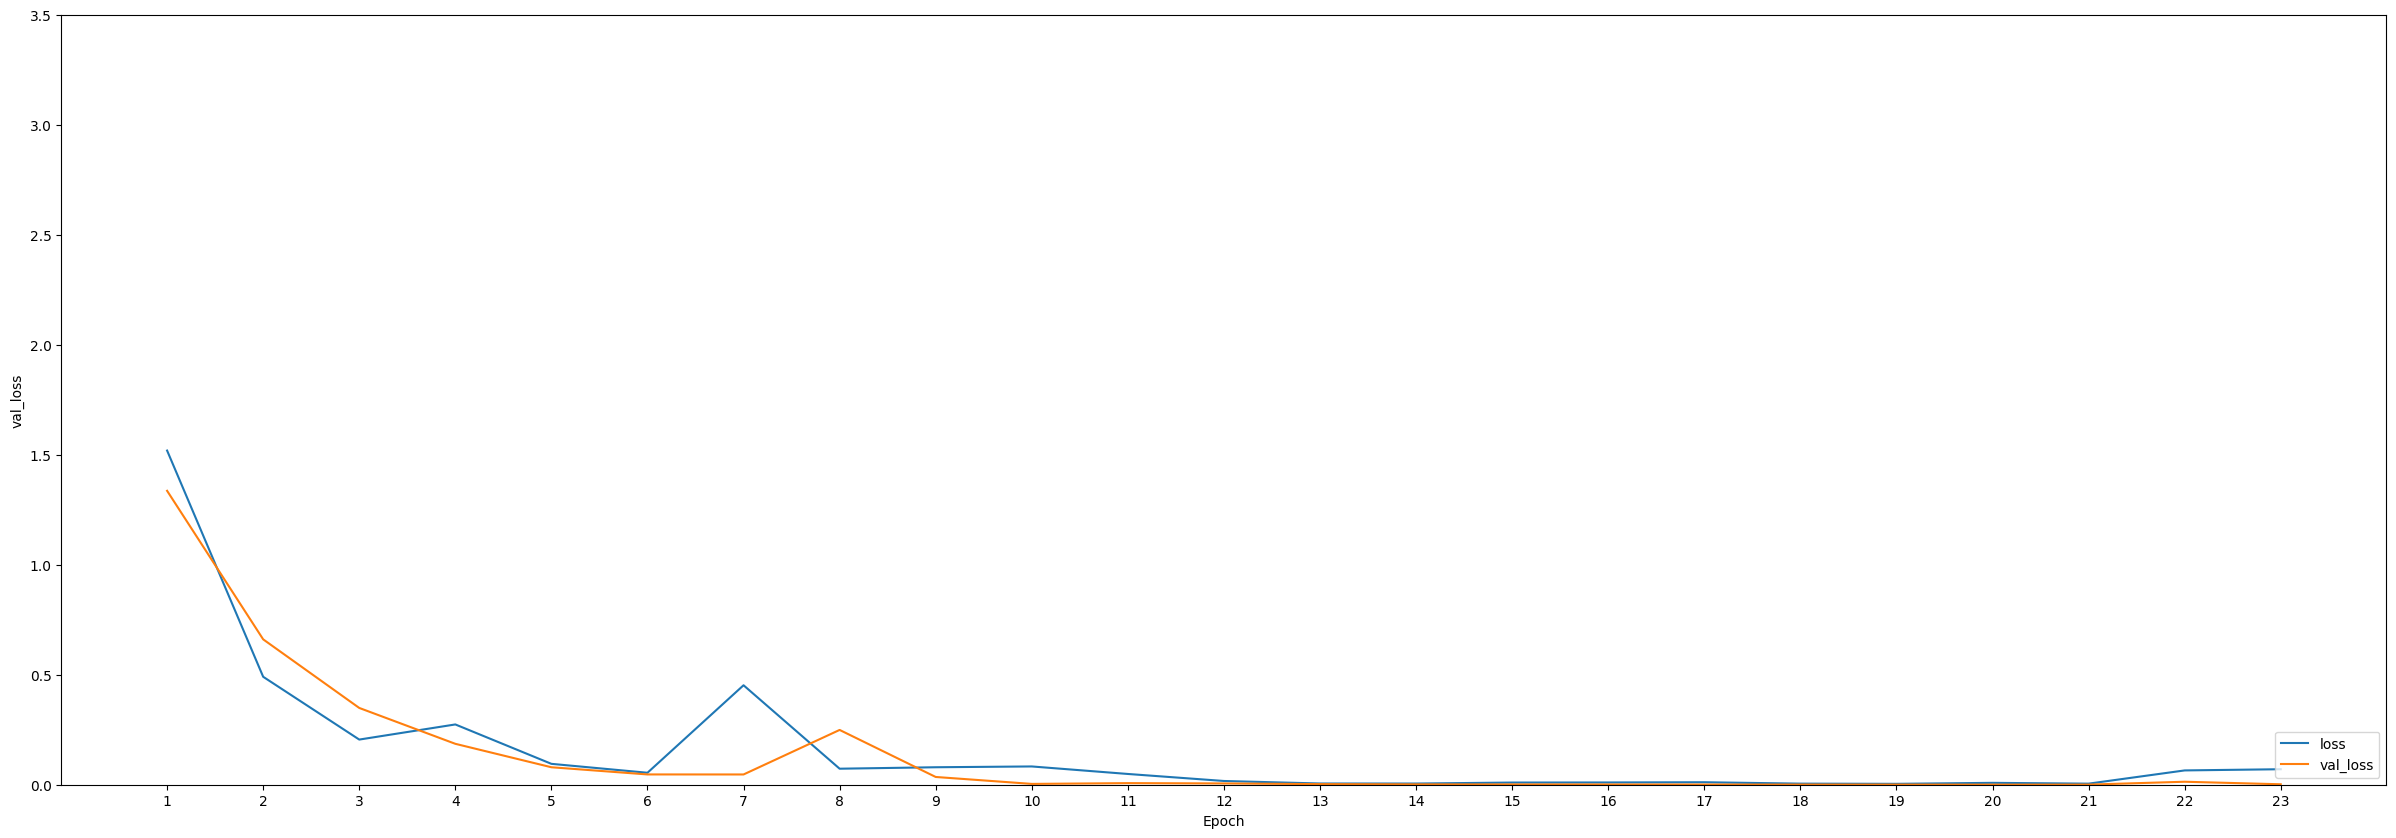

In [7]:
custom_model.save('Efficient_net_custom_doc_type.h5')
plot_metrics_for_training(hist.history)

In [8]:
Yverify=custom_model.predict(X_test)
Yverify=np.argmax(Yverify,axis=1).reshape(-1,1)
Yverify_ground_truth=np.argmax(Y_test,axis=1).reshape(-1,1)
op=classification_report(Yverify_ground_truth,Yverify)
print(op)

11/11 [==============================] - 6s 481ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00        34
           7       1.00      1.00      1.00        32
           8       1.00      1.00      1.00        39
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        67

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00  

In [9]:
path_pdf=input('Enter path of the pdf')
test_img=inference_image_get(path_pdf)
loaded_model=tf.keras.models.load_model('Efficient_net_custom_doc_type.h5')
map=dump_load_map({},1)
preds=loaded_model.predict(test_img.reshape(1,test_img.shape[0],test_img.shape[1],test_img.shape[2]))
op=np.argmax(preds)
print(list(preds[0])[op])
if list(preds[0])[op]<=0.79:
    print('This file belongs to none of the vendors ')
else: 
    pred_class=list(filter(lambda x: map[x] == op, map))[0]
    print(pred_class)
    v_name=pred_class.split('_')[0]
    with open('document_type_mapping.json','r') as default_:
        f=json.load(default_)
    
    d_type=f[pred_class.upper()]
    print(f'This file belongs to  \n  Vendor: {v_name}  \n  Doc Type: {d_type}')

1/1 [==============================] - 1s 977ms/step
0.51116276
This file belongs to none of the vendors 
